#**Week 2 - Transformers 🤖: MLPs in Disguise** (~2 hrs total)

## Part 0 - Setup (~1 min)
Before you begin, please clone this notebook!

**File > Save a copy in Drive**

In [ ]:
from logging import exception
#@title Step 1: Mount drive
#@markdown Run this cell. If prompted, press "Connect to Google Drive" and select your Google account.
#@markdown Then, under the folder icon 📁 on the left panel, you should see the folder **drive** appear.
from google.colab import drive
from IPython.display import display, Markdown, HTML
import os, sys

%load_ext autoreload
%autoreload 2
try:
  drive.mount('/content/drive', force_remount=False)
  sys.path.append('/content/drive/MyDrive/DLE-Jun23/Projects')
  os.chdir('/content/drive/MyDrive/Colab Notebooks/')
  display("⭐ Mounted successfully!")
except:
  display(HTML('<span style="color:red">An error occurred. Try again!</span>'))


Mounted at /content/drive


'⭐ Mounted successfully!'

In [ ]:
!git clone https://github.com/ankit-kothari/minGPT

fatal: destination path 'minGPT' already exists and is not an empty directory.


In [ ]:
%%capture
#@title Step 2: Import packages
!pip install gradio tiktoken transformers bertviz sentence_transformers
!git clone https://github.com/ankit-kothari/minGPT

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/minGPT')
import gradio as gr
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dle_utils.dle_utils import *

import os
import tiktoken
from contextlib import nullcontext

from sentence_transformers import SentenceTransformer
import transformers
from transformers import AutoTokenizer, AutoModel

import bertviz
import matplotlib.pyplot as plt

import torch.nn.functional as F

np.random.seed(0)
torch.manual_seed(0)

### Note: Accessing minGPT

In this assignment, you'll be modifying files in a GitHub repo you have just cloned. This is located in

`/content/drive/MyDrive/Colab Notebooks/minGPT`

After you navigate to this folder, you can open files directly and modify them within Colab.

<img src="https://drive.google.com/uc?id=1v88T2um69mf4W4Jvzt2f-Se8-YlDDZmz" width=300/>

In [ ]:
#@title Step 0: Enter your name to begin.
#@markdown Enter your name as it appears in Slack and run this cell! This is optional -- you can also leave this blank.
Name = ' Ankit' #@param {type:"string"}
filepath = '/content/drive/MyDrive/Colab Notebooks/dle_info.txt'
if os.path.exists(filepath):
  print("Success!")
else:
  if len(Name) == 0:
    print("Please set your name!")
  else:
    try:
      with open(filepath, 'w') as fp:
        fp.write(Name)
        dle_username = Name
      print("Success!")
    except:
      print("Something went wrong...")


Success!


## Part 1: The Life of a Prompt (~10 min)

<img src="https://seeklogo.com/images/C/chatgpt-logo-02AFA704B5-seeklogo.com.png" width='200px' height='200px'>

What happens when we type a prompt into ChatGPT? How does it know what to say? (How can we know it's not just a person pretending to be an AI on the other end? 😏).

ChatGPT uses **GPT-3** as the backbone model for all of its responses. By backbone model, we mean that this is the model that interprets and aims to "understand" the prompt. There are other bells and whistles that are needed to make the experience smoother, but GPT-3 is the brains 🧠 behind everything.

In this section will cover the basics of GPT (Generative Pre-trained Transformer). GPT was developed by OpenAI, and serves as the backbone of their flagship product, Chat-GPT.

We will be working with a simplified version of GPT called minGPT (written by *Andrej Karpathy*) to be a more human-understandable implementation. Also, we'll be using GPT-2, which is a smaller, earlier version of GPT-3. Though different, there are actually very few conceptual differences between GPT-2 and GPT-3!

**TODO**:

Open up ```minGPT/mingpt/model.py``` in the folder tab on the left side of this notebook by double clicking its name. It should then appear on the right hand side of this notebook. The model we will be using is defined under ```class GPT(nn.Module)```.

We'll dig into the model in a second. First, let's just run some examples through it to get a feel.

**Run the cell below.** This cell loads the GPT-2 model and creates a function, `generate_text()`, that generates text using GPT-2 given a prompt.

In [ ]:
from minGPT import mingpt
from mingpt.model import GPT
from mingpt.bpe import BPETokenizer

model = GPT.from_pretrained('gpt2')
tokenizer = BPETokenizer()

def generate_text(prompt, model=model, num_samples=3, num_tokens_per_response=50):
  x = tokenizer(prompt).expand(num_samples, -1)
  print(x)
  response = model.generate(x, max_new_tokens=num_tokens_per_response, do_sample=True, top_k=5)
  print(prompt)
  print('-'*80)
  for i in range(num_samples):
    print(f'Response {i+1}: {tokenizer.decode(response[i].cpu().squeeze())[len(prompt):]}')
    print('-'*80)

number of parameters: 124.44M


downloading https://openaipublic.blob.core.windows.net/gpt-2/models/124M/encoder.json to /root/.cache/mingpt/encoder.json
downloading https://openaipublic.blob.core.windows.net/gpt-2/models/124M/vocab.bpe to /root/.cache/mingpt/vocab.bpe


In [ ]:
#@title Try a prompt
#@markdown In this cell, type in a prompt, starting with the default.
Prompt = 'The Indian Prime Minister Mr. Modi ' #@param {type:"string"}

generate_text(Prompt)

tensor([[  464,  3942,  5537,  4139,  1770,    13, 14637,   220],
        [  464,  3942,  5537,  4139,  1770,    13, 14637,   220],
        [  464,  3942,  5537,  4139,  1770,    13, 14637,   220]])
The Indian Prime Minister Mr. Modi 
--------------------------------------------------------------------------------
Response 1:  has been invited to the White House in the same day, but he was not there.
 It is not clear if he is a guest, or if he is an official of the country, or if he is a guest.
 
--------------------------------------------------------------------------------
Response 2:  (pictured) has been named as the new Prime Minister of India.
The new PM will be named by the Indian Prime Minister of India, and the Prime Minister will be chosen by all India citizens.
In a letter to The Indian Government
--------------------------------------------------------------------------------
Response 3:  has made a strong statement on his government, that the  Modi government is in 1947, a

🎉 Hopefully, the answers from this model made some sense!

If you find that the response is messy, this is in part because the model is spewing out words like a firehose. In practice, ChatGPT does additional tuning to make sure its responses are more natural.

***So what is going on when a prompt is entered into the model?***

We'll be going through a guided tutorial which we call **"The life of a prompt"**. We will take you through all the steps that a prompt goes through before the response is generated.

## Part 2: Input preprocessing (~15 min)

You'll notice in our function ```generate_text``` (the one provided a couple cells up, not in ```model.py```) that we do two steps before feeding the prompt into the model: (1) tokenization, (2) reshaping.

(1) Tokenization is the process of breaking down free text into individual units (tokens). Tokens can be words like "coffee", "cell", or "search". They can also be subwords, such as the word "psychology" broken into "psycho" and "logy". This is what ```tokenize(prompt)``` does.

In the cell below, we'll be using a tokenizer that's a little more understandable. (Read more about it [here](https://huggingface.co/transformers/v4.2.2/main_classes/tokenizer.html)).

**TODO**: Run the line below to load the tokenizer.


In [ ]:
from transformers import AutoTokenizer

autotokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

**TODO**: Then, try a few different input strings to see how tokenization works:

In [ ]:
# Try changing input_string with a few of your own sentences!
input_string = "Ethiopian coffee tastes best with 10 minutes of brewing."

autotokenizer.tokenize(input_string)

['ethiopian',
 'coffee',
 'tastes',
 'best',
 'with',
 '10',
 'minutes',
 'of',
 'brewing',
 '.']

If you try a word like "enumeration", you'll notice the tokens are ['en', '##ume', '##ration']. The double hash "##" is used to indicate subwords that are part of larger words.

This symbol is used by **Byte Pair Encoding (BPE)**, which is commonly used in NLP tasks. You'll also notice that it removes capitalization since it doesn't affect word meanings in most cases. (This is what the uncased means in `bert-base-uncased`).

The next step is to convert tokens into input ids: Each token is mapped to an identification number in the overall vocabulary.

**TODO**: In the cell below, find out what the input id for the word "coffee" is. Also, figure out what the size of the vocabulary is.

In [ ]:
# You'll need the vocab first.
vocab = autotokenizer.get_vocab()

# Grab the input id for 'coffee'
coffee_vocab_id = vocab.get("coffee")
vocab_length = len(vocab)


In [ ]:
coffee_vocab_id

4157

In [ ]:
check('2.1.1', tuple([coffee_vocab_id, vocab_length]))

## Correct! 🎉

Easy enough, right? The tokenizer maps each prompt to its tokens, and then mapping those tokens to their input ids.

Next, we are just left with reshaping the input.

There's not too much to say about reshaping except for the fact that the line ```x = tokenizer(prompt).expand(num_samples, -1)``` has the ```expand``` component just to repeat the same prompt ```num_samples``` of times, each time aiming to get a different response to the prompt. (Think of it as a different "try" each time).

___


## Part 3: Embeddings (~45 min)

Scroll to line 283 in ```model.py```, where you'll find the function ```generate``` (different than the ```generate_text``` function we just worked with.) Try reading over this code to get a high-level understanding.

The core of this function is found in line 293:

```logits, _ = self(idx_cond)```.

The self function calls ```forward```. In the ```forward``` function, you will find on line 267 our first focus point:

```tok_emb = self.transformer.wte(idx)```

Here, ```wte``` stands for word-token embedding.

**TODO**: In the cell below, try running a sample prompt through this layer. Remember to first tokenize and reshape the prompt!



In [ ]:
prompt = 'Into the rabbit hole we go'
x = autotokenizer.tokenize(prompt)
x_input_ids = [vocab.get(word) for word in x]
x_input_ids

[2046, 1996, 10442, 4920, 2057, 2175]

In [ ]:
# Make sure the prompt is tokenized and reshaped
prompt = 'Into the rabbit hole we go'
x = tokenizer(prompt).expand(1,-1)
print(x)

# Pass x through the model.transformer.wte function
x_embedding = model.transformer.wte(x)

print(x_embedding.size())

tensor([[ 5317,    78,   262, 22746,  7604,   356,   467]])
torch.Size([1, 7, 768])


What do you notice about the size of ```x_embedding``` vs ```x```?
What dimension has grown?


The following code defines ```model.transformer.wte```:

```wte = nn.Embedding(config.vocab_size, config.n_embd)```

An embedding layer is used, which you can learn more about [here](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).

**TODO**: To familiarize yourself with embedding layers, initialize an ```nn.Embedding``` layer with ```num_embeddings = 10``` and ```embedding_dim = 5```. Then, come up with an input, ```in_x```, that produces an output of size (2, 4, 5) after it's passed through this embedding layer.

Here are a couple hints:
1. ```num_embeddings``` refers to the highest number any index can be.
2. Look into Pytorch tensor type ```torch.LongTensor```.

In [ ]:
# Create embedding layer
 #10 is the vocab size,
 #5 is the embedding dimension
emb_layer = nn.Embedding(10,5)
# Create input that produces output of size (2, 4, 5)
T=4
D=5
n_samples=2

#creating an input tensor where the vector or ids are between the vocublary indices <10 in this case
in_x =torch.tensor([[1, 2, 3, 4],
                       [5, 6, 7, 8]])


out_x = emb_layer(in_x)
out_x.size()

torch.Size([2, 4, 5])

In [ ]:
check('2.1.2', out_x)

## Correct! 🎉

Great! So what does this all mean?

In the shape (2, 4, 5), the 2 refers to the number of samples. For each sample, there is a (4, 5) tensor that represents the prompt. The 4 refers to the length of each prompt (number of tokens), and the final dimension 5 refers to the fact that each token is represented by a length-5 vector.

**In a nutshell**:

*Token -> nn.Embedding -> vector of size ```embedding_dim```*

```nn.Embedding``` is a trainable layer, meaning that as the model sees more data, the exact way in which it associates the embeddings to each token changes.

Let's see an example of this.

**TODO**:

In the cell below, create your own ```nn.Embedding``` layer that has the same number of input and output dimensions as ```model.transformer.wte```. Hint: You can find this out by just printing the object itself out.

In [ ]:
model.transformer.wte

Embedding(50257, 768)

In [ ]:
# Initialize the embedding layer
embedding_dim =768
num_embeddings =50257
untrained_embedding = nn.Embedding(num_embeddings, embedding_dim)


In [ ]:
check('2.1.3', untrained_embedding)

## Correct! 🎉

A great gutcheck for this is to ask yourself what the first dimension refers to in the context of the tokenizer.

Next, let's take two similar words and find out how well it associates them together **before any training**.

To measure the similarity between two embedding vectors, we'll be using a score called cosine similarity (which is ```F.cosine_similarity``` in PyTorch) to compare the embeddings. Very similar embeddings will have a cosine similarity closer to 1, and very dissimilar embeddings will have cosine similarity closer to 0. **Hint: You will need to use the ```dim``` argument to compare the right dimension (the one with 768).**

Finally, populate ```similarity_untrained``` with the cosine similarity as a numpy float. **You'll need to turn a torch tensor into numpy for this!** (Also, think about which dimension actually has the answer you want if you're running into dimension issues).


In [ ]:
# Use tokenizer to tokenize 'dog' and 'canine'
word1 = "dog"
word2 = "canie"

# Extract embeddings
word_1_tokenized = tokenizer(word1).expand(1,-1)
word_2_tokenized = tokenizer(word2).expand(1,-1)
word1_emb = untrained_embedding(word_1_tokenized)
word2_emb = untrained_embedding(word_2_tokenized)

In [ ]:
torch.squeeze(word1_emb).shape

torch.Size([768])

In [ ]:
tokenizer(word2)

tensor([[5171,  494]])

In [ ]:
# Use tokenizer to tokenize 'dog' and 'canine'
word1 = "dog"
word2 = "canie"

# Extract embeddings
word_2_tokenized = tokenizer(word2)
word_1_tokenized = tokenizer(word1)

print(word_2_tokenized)
word_2_tokenized

word1_emb = untrained_embedding(word_1_tokenized)
word2_emb = untrained_embedding(word_2_tokenized)
word2_emb = torch.mean(word2_emb, dim=1, keepdim=True)

#shapes
print(word1_emb.shape)
print(word2_emb.shape)

#normalized
word1_emb_normalized =torch.squeeze(word1_emb).reshape(1,-1)
word2_emb_normalized =torch.squeeze(word2_emb).reshape(1,-1)

print(word1_emb_normalized.shape)

# Compute the cosine similarity between word1_emb and word2_emb
similarity_untrained = F.cosine_similarity(word1_emb_normalized, word2_emb_normalized)
similarity_untrained = similarity_untrained.detach().numpy() # Convert to numpy float

print(similarity_untrained)

tensor([[5171,  494]])
torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
torch.Size([1, 768])
[0.01145177]


**TODO**:
Next, you will be using the ```wte``` (word token embedding) layer from the model that has already been trained. The goal is to notice the difference before and after model training. The embedding produced after training should be much better than random.

In [ ]:
# Use tokenizer to tokenize 'dog' and 'canine'
word1 = "dog"
word2 = "canie"

# Extract embeddings
word_2_tokenized = tokenizer(word2)
word_1_tokenized = tokenizer(word1)

print(word_2_tokenized)
word_2_tokenized

word1_emb = model.transformer.wte(word_1_tokenized)
word2_emb = model.transformer.wte(word_2_tokenized)
word2_emb = torch.mean(word2_emb, dim=1, keepdim=True)

#shapes
print(word1_emb.shape)
print(word2_emb.shape)

#normalized
word1_emb_reshaped =torch.squeeze(word1_emb).reshape(1,-1)
word2_emb_reshaped =torch.squeeze(word2_emb).reshape(1,-1)

print(word1_emb_normalized.shape)

# Compute the cosine similarity
similarity_trained = F.cosine_similarity(word1_emb_reshaped, word2_emb_reshaped)
similarity_trained = similarity_trained.detach().numpy() # Convert to numpy float

print(similarity_trained)

tensor([[5171,  494]])
torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
torch.Size([1, 768])
[0.33958447]


In [ ]:
check('2.1.4', tuple([similarity_untrained, similarity_trained]))

## Correct! 🎉

Great! If done correctly, you should find that the random initialization has a very low similarity score between two related words ("dog", "canine").

After training, the model's ```wte``` layer associates similar words more closely. Another way to look at this is that the model's embeddings represent "meaning" much more strongly.

Let's try one more exercise here. Rather than find the embedding for a single word, can we extract the embedding for a whole sentence?

Because the embedding layer will produce a 768-sized vector for each token, we will need to find a way to "squash" that into a fixed-length vector. One common method is just to take the average value along each of the 768 dimensions.

**TODO**:
In the cell below, tokenize the prompt and extract the embeddings. What are the dimensions of the embeddings? Compute the mean embedding.

In [ ]:
sentence = "Dogs are one of the most popular pets in the world."

# Tokenize sentence and extract embedding from the trained layer
sentence_emb_tokenized = tokenizer(sentence)
print(sentence_emb_tokenized.shape)
sentence_emb = model.transformer.wte(sentence_emb_tokenized)
print(sentence_emb.shape)
sentence_emb = torch.mean(sentence_emb, dim=1, keepdim=True)
print(sentence_emb.shape)

# Compute the mean of the layer across all words in the sentence.
mean_emb = torch.squeeze(sentence_emb).reshape(1,-1)
print(mean_emb.shape)

torch.Size([1, 13])
torch.Size([1, 13, 768])
torch.Size([1, 1, 768])
torch.Size([1, 768])


In [ ]:
check('2.1.5', mean_emb)

## Correct! 🎉

Let's test out how well this works on the task of comparing sentence. Below are three sentences. The first sentence is a linear regression formula, and the second and third are statements about dogs. The idea is that the cosine similarity between sentence B and sentence C should be higher than the cosine similarity between sentence A and B or A and C.

**TODO**: Run the following cell. Then, compute the cosine similarities below (as numpy floats).

In [ ]:
# Tokenize sentence and extract embedding from the trained layer
def sent_embedding(sentence):
    sentence_emb_tokenized = tokenizer(sentence)
    sentence_emb = model.transformer.wte(sentence_emb_tokenized)
    sentence_emb = torch.mean(sentence_emb, dim=1, keepdim=True)
    # Compute the mean of the layer across all words in the sentence.
    mean_emb = torch.squeeze(sentence_emb).reshape(1,-1)
    return mean_emb

def similarity(sentence1, sentence2):
  # Compute the cosine similarity
  sentence1 = F.normalize(sentence1, dim=-1)
  sentence2 = F.normalize(sentence2, dim=-1)
  similarity_trained = F.cosine_similarity(sentence1, sentence2)
  similarity_trained = similarity_trained.detach().numpy() # Convert to numpy float
  return  similarity_trained


sentenceA = "y = β₀ + β₁x₁ + β₂x₂ + … + βₚxₚ + ε"
sentenceB = "Dogs are one of the most popular pets in the world."
sentenceC = "There are over 300 different breeds of dogs."

In [ ]:
# Extract mean sentence embeddings for each sentence.
embA = sent_embedding(sentenceA)
embB = sent_embedding(sentenceB)
embC = sent_embedding(sentenceC)

# Compute the cosine similarity for each pair of sentences and convert to a numpy float
ABsim = similarity(embA, embB)
BCsim = similarity(embB, embC)
ACsim = similarity(embA, embC)

print(ABsim, BCsim, ACsim)

[0.5131977] [0.84531766] [0.6010431]


In [ ]:
check('2.1.6', tuple([ABsim, BCsim, ACsim]))

## Correct! 🎉

Now let's see if this works on a larger scale. In the variable ```SENTENCES``` is a list of 100 sentences. 90 of these sentences are about cats or dogs, while 10 are about statistics.


**TODO**: Can you use sentence embeddings to figure out which 10 are about statistics **without looking at them**?

This part is open-ended. In general terms, you should: (1) extract and compute the mean embeddings for each sentence. (2) Compare the embeddings with one another. For example, you could try a [clustering method](https://scikit-learn.org/stable/modules/clustering.html)!

Once you finish, populate ```outlier_idx``` with a list of the indices (a numpy array) in ```SENTENCES``` which contain the statistics sentences.

In [ ]:
SENTENCES[0]

'Dogs are often used in therapy to help people with emotional and physical challenges.'

In [ ]:
# Your code here
import pandas as pd
sentence_example = SENTENCES[0]

sentence_embeddings = [torch.squeeze(sent_embedding(sentence)).detach().numpy() for sentence in SENTENCES]
sent_df = pd.DataFrame(sentence_embeddings)
print(sent_df.shape)

#K-means clustering
from sklearn.cluster import KMeans
# Perform K-means clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(sent_df)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add the cluster labels to the DataFrame
sent_df['Cluster'] = cluster_labels

# Print the DataFrame with cluster labels
print(sent_df.groupby(['Cluster']).size())

outlier_idx = sent_df[sent_df['Cluster']==0].index

(100, 768)
Cluster
0    10
1    90
dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
check('2.1.7', outlier_idx)

## Correct! 🎉

Next, we will be covering the ```block```, which is referenced on line 148 and defined starting line 73:

Each block consists of two parts: ```self.attn``` and ```self.mlpf```. We'll focus on ```self.attn```, as ```self.mlpf``` is conceptually just an MLP.

The attention mechanism is the core of what makes a Transformer, a Transformer.


## Part 3: Self-Attention (~30 min)

If you  examine ```model.transformer.h```, you will see a list of blocks, which each contain their own ```attn``` layer.

Let's say we have a sentence: "All the dogs bark at John for food". Intuitively, we understand that the word "bark" refers to the dogs, rather than John. Does the model understand the same?

We will be testing this out in a little experiment below.

First, tokenize the sentence and store its embedding using ```wte``` (use only one sample).


In [ ]:
input_string = 'All the dogs bark at John for food'

# Tokenize and extract embeddings
x = tokenizer(input_string)
x_emb = model.transformer.wte(x)

**TODO**:

Next, go to line 29 where ```CausalSelfAttention``` is defined.

We want to extract the attentions directly to see what's going on. After line 64, add ```return att```. This should come after ```att = F.softmax(att, dim=-1)``` and before ```att = self.attn_dropout(att)```. Next, comment out line 63: ```att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))```. This is done so to save computation, but we want the whole attention matrix for interpretability purposes.

Save ```model.py``` and return back to this notebook.

Now, in the cell below, do the following steps:

1. First, examine ```model.transformer.h```. You will notice a ```ModuleList``` containing 12 blocks. We'll only be using the first block in this list. Pass the tokenized sentence ```x_emb``` into this first block and extract the attention matrix for your sentence. The output should have shape 1x12x8x8, where 12 refers to the number of attention heads. (Note: the number of blocks is not the same as the number of attention heads, they just happen to be both 12!) Then, take the mean attention across all 12 attention heads so that you are left with a tensor of size 8x8. Hint: You can convert a tensor of dimension (1, 8, 8) to dimension (8, 8) by just calling ```.squeeze(0)``` on that tensor.

In [ ]:
model.transformer.h

ModuleList(
  (0-11): 12 x Block(
    (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (attn): CausalSelfAttention(
      (c_attn): Linear(in_features=768, out_features=2304, bias=True)
      (c_proj): Linear(in_features=768, out_features=768, bias=True)
      (attn_dropout): Dropout(p=0.1, inplace=False)
      (resid_dropout): Dropout(p=0.1, inplace=False)
    )
    (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): ModuleDict(
      (c_fc): Linear(in_features=768, out_features=3072, bias=True)
      (c_proj): Linear(in_features=3072, out_features=768, bias=True)
      (act): NewGELU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)

In [ ]:
first_block = model.transformer.h[0]
first_block

Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): CausalSelfAttention(
    (c_attn): Linear(in_features=768, out_features=2304, bias=True)
    (c_proj): Linear(in_features=768, out_features=768, bias=True)
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): ModuleDict(
    (c_fc): Linear(in_features=768, out_features=3072, bias=True)
    (c_proj): Linear(in_features=3072, out_features=768, bias=True)
    (act): NewGELU()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [ ]:
#to access the casual attention module
first_block.attn

CausalSelfAttention(
  (c_attn): Linear(in_features=768, out_features=2304, bias=True)
  (c_proj): Linear(in_features=768, out_features=768, bias=True)
  (attn_dropout): Dropout(p=0.1, inplace=False)
  (resid_dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
x_emb.shape

torch.Size([1, 8, 768])

In [ ]:
# Using only the first block, extract the attention matrix and take the mean over all 12 attention heads
attn_mat = first_block.attn(x_emb)
attn_mat.shape

torch.Size([1, 12, 8, 8])

In [ ]:
mean_attention_heads = torch.mean(attn_mat, dim=1)
mean_attention_heads.shape

torch.Size([1, 8, 8])

In [ ]:
attn_mat = mean_attention_heads.squeeze()
attn_mat.shape

torch.Size([8, 8])

In [ ]:
attn_mat
#'All the dogs bark at John for food'

tensor([[0.4085, 0.0942, 0.0538, 0.0511, 0.1120, 0.1038, 0.1199, 0.0567],
        [0.1316, 0.2520, 0.0633, 0.0660, 0.1358, 0.0958, 0.1698, 0.0857],
        [0.0581, 0.0671, 0.3571, 0.1113, 0.0765, 0.0737, 0.0908, 0.1653],
        [0.0615, 0.0720, 0.1572, 0.3954, 0.0802, 0.0531, 0.0915, 0.0892],
        [0.1191, 0.0989, 0.0622, 0.1150, 0.2980, 0.0749, 0.1546, 0.0772],
        [0.1031, 0.0728, 0.0643, 0.0653, 0.0798, 0.4705, 0.0888, 0.0554],
        [0.1084, 0.1066, 0.0574, 0.0898, 0.1317, 0.0750, 0.3462, 0.0848],
        [0.0691, 0.0705, 0.1426, 0.0611, 0.0895, 0.0538, 0.0908, 0.4224]],
       grad_fn=<SqueezeBackward0>)

In [ ]:
check('2.1.8', attn_mat)

## Correct! 🎉


2. At this point, you can also visualize the attention matrix by using the line ```plt.imshow(attn_mat)```. Next, we're interested in what the word "bark" is paying attention to. For each 8x8 tensor, extract the row that corresponds to the word "bark" (think about what index this is from the prompt). You should be left with a tensor of length 8.

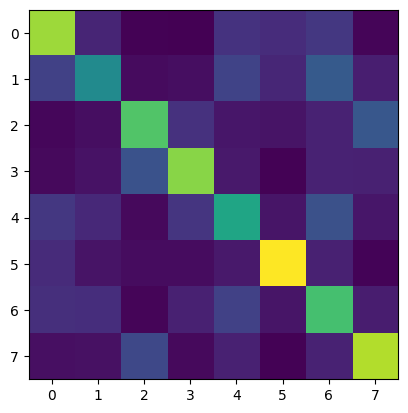

In [ ]:
# Run this cell to visualize what the attention matrix looks like
plt.imshow(attn_mat.detach().numpy())

In [ ]:
# Extract just the row for the word 'bark'
attn_row = attn_mat[3]
attn_row

tensor([0.0615, 0.0720, 0.1572, 0.3954, 0.0802, 0.0531, 0.0915, 0.0892],
       grad_fn=<SelectBackward0>)

In [ ]:
check('2.1.9', attn_row)

## Correct! 🎉

4. Finally, return a dictionary that has each word in the sentence as a key and its attention score as the value (as a numpy float). It should look something like ```{'All': 0.01, 'the': 0.22, ...}```

Which word does "bark" attend to the most (besides "bark")? Between the dog and John, which word does "bark" attend more strongly towards?

In [ ]:
# Populate dictionary of words and values
# Remember to convert the attention scores to a numpy float!
input_string_words = input_string.split(" ")
attn_dict = {input_string_words[i]:attn_row[i] for i in range(len(attn_row))}

In [ ]:
attn_dict

{'All': tensor(0.0615, grad_fn=<SelectBackward0>),
 'the': tensor(0.0720, grad_fn=<SelectBackward0>),
 'dogs': tensor(0.1572, grad_fn=<SelectBackward0>),
 'bark': tensor(0.3954, grad_fn=<SelectBackward0>),
 'at': tensor(0.0802, grad_fn=<SelectBackward0>),
 'John': tensor(0.0531, grad_fn=<SelectBackward0>),
 'for': tensor(0.0915, grad_fn=<SelectBackward0>),
 'food': tensor(0.0892, grad_fn=<SelectBackward0>)}

In [ ]:
# If this check isn't working, just make sure 'dog' has the highest score (next to 'bark')
#check('2.1.10', attn_dict)

Let's try this for a sentence of your choice. (Sometimes, the tokenizer might split up a word into two pieces, so pick your sentences and attentions carefully)

In the cell below, combine the code you wrote in the lines above and process the new input string to return the attention dictionary.

In [ ]:
def sent2attn_matrix(sent):
  x = tokenizer(sent)
  x_emb = model.transformer.wte(x)
  first_block = model.transformer.h[0]
  attn_mat = first_block.attn(x_emb)
  mean_attention_heads = torch.mean(attn_mat, dim=1)
  attn_mat = mean_attention_heads.squeeze()
  attn_row = attn_mat[0]
  input_string_words = sent.split(" ")
  attn_dict = {input_string_words[i]:attn_row[i] for i in range(len(attn_row))}
  return attn_dict



input_string = 'I am a good boy'
attn_dict = sent2attn_matrix(input_string)
print(attn_dict)

{'I': tensor(0.5120, grad_fn=<SelectBackward0>), 'am': tensor(0.1359, grad_fn=<SelectBackward0>), 'a': tensor(0.1481, grad_fn=<SelectBackward0>), 'good': tensor(0.1094, grad_fn=<SelectBackward0>), 'boy': tensor(0.0947, grad_fn=<SelectBackward0>)}


In [ ]:
#check('2.1.11', attn_dict)

Don't worry if this part is a bit involved! Feel free to ask away on Slack. (Think through what each dimension is referring to at each step).

Do the attention scores still make sense? It would be great to share your thoughts! (You can alter the block you are examining, or even the method of taking the average over all heads).

At the end of the day, interpreting attention scores are a finicky business, so don't be discouraged if you aren't getting exactly what you're looking for!

## Part 4: Outputs (~20 min)

Together, the input preprocessing, embeddings, and self-attention are the key parts of a transformer. There are many other components that make it work, and we will conver some of them next week (and other parts, you can familiarize on your own).

Finally, we'll focus on how the output is processed.

Delete the ```return att``` line you've injected in script, and uncomment out line 63. Remember to save! Now, return to line 293: ```logits, _ = self(idx_cond)```. We can recreate this line below:

In [ ]:
# Just run the line below!

input_string = 'To make bread, first add'
x = tokenizer(input_string)

logits_orig, _ = model(x)

In [ ]:
x

tensor([[2514,  787, 8509,   11,  717,  751]])

In [ ]:
logits_orig.shape

torch.Size([1, 6, 50257])

Examine the size of ```logits```. What does each dimension refer to?

Next, we only want to know what the model's next word prediction is after the final word of our input. In the cell below, extract the logits from the last word.

In [ ]:
# Just extract the last in the sequence. Think carefully about which dimension you are extracting from!
logits = logits_orig[:, -1, :]

In [ ]:
logits.shape

torch.Size([1, 50257])

In [ ]:
check('2.1.12', logits)

## Correct! 🎉

In the cell below, apply the softmax layer to the logits. This makes it so that all the probabilities assigned to each vocab word sum to one.

In [ ]:
# Just copy-paste line 301
probs = F.softmax(logits, dim=1)
probs[0:10]

tensor([[8.7109e-05, 4.3731e-05, 5.5828e-07,  ..., 8.1838e-09, 1.9897e-08,
         1.6580e-05]], grad_fn=<SliceBackward0>)

Next, compute the top ten predictions using ```torch.topk```. Then, populate a dictionary ```scores_dict``` where the keys are ten tokens and the values are their relative probabilities. The keys should be strings and the values should be numpy floats. You'll have to do some Pytorch tensor manipulation and data type conversions here! (Remember, use ```tokenizer.decode()``` to convert indices back into the words they refer to)

In [ ]:
tokenizer.decode(torch.tensor([262]))

' the'

In [ ]:
# Extract top 10 using torch.topk
top_probs, top10 = torch.topk(probs, k=10, dim=1)
top_probs=top_probs.squeeze(0).detach().numpy()
top10=top10.squeeze(0).detach().numpy()

print("Top Probabilities Shape:", top_probs.shape)
print("Top Indices Shape:", top10.shape)


# Populate the dictionary
scores_dict = {tokenizer.decode(torch.tensor([top10[i]])):top_probs[i] for i in range(len(top10))}

Top Probabilities Shape: (10,)
Top Indices Shape: (10,)


In [ ]:
tokenizer.decode(torch.tensor([top10[0]]))

' the'

In [ ]:
scores_dict

{' the': 0.204424,
 ' a': 0.11020867,
 ' some': 0.057291437,
 ' 1': 0.03690852,
 ' flour': 0.026994199,
 ' to': 0.02638669,
 ' 2': 0.025335884,
 ' butter': 0.02435032,
 ' in': 0.017543495,
 ' your': 0.017139781}

In [ ]:
check('2.1.13', scores_dict)

## Correct! 🎉

You'll notice in the code, each logit is divided by a temperature. This smooths out the predictions such that there is less of a relative difference between the logits for each word.

Let's see how this affects the relative predicted probabilities.
Now, divide logits by a constant ```temperature=1.5```. Repeat the same steps in as the previous question and produce ```scores_dict_temp```, which is the scores after using temperature 1.5.

In [ ]:
logits_temp, _ = model(x)
logits = logits_temp[:, -1, :]
probs = F.softmax(logits, dim=1)
top_probs, top10 = torch.topk(probs, k=10, dim=1)
top_probs=top_probs.squeeze(0).detach().numpy()
top10=top10.squeeze(0).detach().numpy()

print("Top Probabilities Shape:", top_probs.shape)
print("Top Indices Shape:", top10.shape)


# Populate the dictionary
scores_dict_temp = {tokenizer.decode(torch.tensor([top10[i]])):top_probs[i] for i in range(len(top10))}

Top Probabilities Shape: (10,)
Top Indices Shape: (10,)


In [ ]:
scores_dict_temp

{' butter': 0.082397364,
 ' water': 0.066489086,
 ' salt': 0.0632457,
 ' flour': 0.054999564,
 ' the': 0.05380918,
 ' milk': 0.047890656,
 ' it': 0.029871732,
 ' yeast': 0.027709372,
 ' a': 0.024515454,
 ' sugar': 0.022190996}

In [ ]:
check('2.1.14', tuple([scores_dict, scores_dict_temp]))

## Correct! 🎉

Notice that it does not change the relative order of probabilities.

However, it will change their chance of being picked if we sample them at random.

In the cell below, sample the next word using ```torch.multinomial```. After decoding the word, does the choice surprise you?

Try running a few examples by changing ```num_samples``` to 10.

In [ ]:
num_samples=10
sampled_indices = torch.multinomial(probs, num_samples, replacement=True)

indices_list = sampled_indices.squeeze().tolist()

for i in indices_list:
  next_word=tokenizer.decode(torch.tensor([i]))
  print(next_word)




 water
 cheese
 the
 chopped
 the
 chopped
 water
 butter
 the
 the


In [ ]:
next_word = tokenizer.decode(torch.tensor([610]))
next_word

' ar'

You'll notice that by sampling, we get a more diverse choice of words, but perhaps more random.

In general, this is a trade-off for large language models -- we want more creativity, but it risks non-sense responses!
___

## Summary

Congrats! You got through the main parts of the GPT model!

Feel free to continue playing around with prompts from the questions in this assignment and see if any responses surprise you!